In [1]:
library('urca')
library("Hmisc")
library('Metrics')
library('zoo')
library('tseries')
library('forecast')
library('fpp2')
library('astsa')
library('dynlm')
library('FinTS')

Warning message:
"package 'urca' was built under R version 4.3.1"


Warning message:
"package 'Hmisc' was built under R version 4.3.1"

Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units



Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Warning message:
"package 'tseries' was built under R version 4.3.1"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Warning message:
"package 'forecast' was built under R version 4.3.1"

Attaching package: 'forecast'


The following object is masked from 'package:Metrics':

    accuracy


Warning message:
"package 'fpp2' was built under R version 4.3.1"
── Attaching packages ────────────────────────────────────────────── fpp2 2.5 ──

✔ ggplot2   3.4.2     ✔ expsmooth 2.3  
✔ fma       2.5       

Warning message:
"package 'fma' was built under R version 4.3.1"
Warning message:
"package 'expsmooth' was built under R version 4.3.1"
── Conflicts ──────

In [2]:
interp_urdf <- function(urdf, level="5pct") {
  if(class(urdf) != "ur.df") stop('parameter is not of class ur.df from urca package')
  if(!(level %in% c("1pct", "5pct", "10pct") ) ) stop('parameter level is not one of 1pct, 5pct, or 10pct')

  cat("========================================================================\n")
  cat( paste("At the", level, "level:\n") )
  if(urdf@model == "none") {
    cat("The model is of type none\n")
    tau1_crit = urdf@cval["tau1",level]
    tau1_teststat = urdf@teststat["statistic","tau1"]
    tau1_teststat_wi_crit = tau1_teststat > tau1_crit
    if(tau1_teststat_wi_crit) {
      cat("tau1: The null hypothesis is not rejected, unit root is present\n")
    } else {
      cat("tau1: The null hypothesis is rejected, unit root is not present\n")
    }
  } else if(urdf@model == "drift") {
    cat("The model is of type drift\n")
    tau2_crit = urdf@cval["tau2",level]
    tau2_teststat = urdf@teststat["statistic","tau2"]
    tau2_teststat_wi_crit = tau2_teststat > tau2_crit
    phi1_crit = urdf@cval["phi1",level]
    phi1_teststat = urdf@teststat["statistic","phi1"]
    phi1_teststat_wi_crit = phi1_teststat < phi1_crit
    if(tau2_teststat_wi_crit) {
      # Unit root present branch
      cat("tau2: The first null hypothesis is not rejected, unit root is present\n")
      if(phi1_teststat_wi_crit) {
        cat("phi1: The second null hypothesis is not rejected, unit root is present\n")
        cat("      and there is no drift.\n")
      } else {
        cat("phi1: The second null hypothesis is rejected, unit root is present\n")
        cat("      and there is drift.\n")
      }
    } else {
      # Unit root not present branch
      cat("tau2: The first null hypothesis is rejected, unit root is not present\n")
      if(phi1_teststat_wi_crit) {
        cat("phi1: The second null hypothesis is not rejected, unit root is present\n")
        cat("      and there is no drift.\n")
        warning("This is inconsistent with the first null hypothesis.")
      } else {
        cat("phi1: The second null hypothesis is rejected, unit root is not present\n")
        cat("      and there is drift.\n")
      }
    }
  } else if(urdf@model == "trend") {
    cat("The model is of type trend\n")
    tau3_crit = urdf@cval["tau3",level]
    tau3_teststat = urdf@teststat["statistic","tau3"]
    tau3_teststat_wi_crit = tau3_teststat > tau3_crit
    phi2_crit = urdf@cval["phi2",level]
    phi2_teststat = urdf@teststat["statistic","phi2"]
    phi2_teststat_wi_crit = phi2_teststat < phi2_crit
    phi3_crit = urdf@cval["phi3",level]
    phi3_teststat = urdf@teststat["statistic","phi3"]
    phi3_teststat_wi_crit = phi3_teststat < phi3_crit
    if(tau3_teststat_wi_crit) {
      # First null hypothesis is not rejected, Unit root present branch
      cat("tau3: The first null hypothesis is not rejected, unit root is present\n")
      if(phi3_teststat_wi_crit) {
        # Second null hypothesis is not rejected
        cat("phi3: The second null hypothesis is not rejected, unit root is present\n")
        cat("      and there is no trend\n")
        if(phi2_teststat_wi_crit) {
          # Third null hypothesis is not rejected
          # a0-drift = gamma = a2-trend = 0
          cat("phi2: The third null hypothesis is not rejected, unit root is present\n")
          cat("      there is no trend, and there is no drift\n")
        } else {
          # Third null hypothesis is rejected
          cat("phi2: The third null hypothesis is rejected, unit root is present\n")
          cat("      there is no trend, and there is drift\n")
        }
      }
      else {
        # Second null hypothesis is rejected
        cat("phi3: The second null hypothesis is rejected, unit root is present\n")
        cat("      and there is trend\n")
        if(phi2_teststat_wi_crit) {
          # Third null hypothesis is not rejected
          # a0-drift = gamma = a2-trend = 0
          cat("phi2: The third null hypothesis is not rejected, unit root is present\n")
          cat("      there is no trend, and there is no drift\n")
          warning("This is inconsistent with the second null hypothesis.")
        } else {
          # Third null hypothesis is rejected
          cat("phi2: The third null hypothesis is rejected, unit root is present\n")
          cat("      there is trend, and there may or may not be drift\n")
          warning("Presence of drift is inconclusive.")
        }
      }
    } else {
      # First null hypothesis is rejected, Unit root not present branch
      cat("tau3: The first null hypothesis is rejected, unit root is not present\n")
      if(phi3_teststat_wi_crit) {
        cat("phi3: The second null hypothesis is not rejected, unit root is present\n")
        cat("      and there is no trend\n")
        warning("This is inconsistent with the first null hypothesis.")
        if(phi2_teststat_wi_crit) {
          # Third null hypothesis is not rejected
          # a0-drift = gamma = a2-trend = 0
          cat("phi2: The third null hypothesis is not rejected, unit root is present\n")
          cat("      there is no trend, and there is no drift\n")
          warning("This is inconsistent with the first null hypothesis.")
        } else {
          # Third null hypothesis is rejected
          cat("phi2: The third null hypothesis is rejected, unit root is not present\n")
          cat("      there is no trend, and there is drift\n")
        }
      } else {
        cat("phi3: The second null hypothesis is rejected, unit root is not present\n")
        cat("      and there may or may not be trend\n")
        warning("Presence of trend is inconclusive.")
        if(phi2_teststat_wi_crit) {
          # Third null hypothesis is not rejected
          # a0-drift = gamma = a2-trend = 0
          cat("phi2: The third null hypothesis is not rejected, unit root is present\n")
          cat("      there is no trend, and there is no drift\n")
          warning("This is inconsistent with the first and second null hypothesis.")
        } else {
          # Third null hypothesis is rejected
          cat("phi2: The third null hypothesis is rejected, unit root is not present\n")
          cat("      there may or may not be trend, and there may or may not be drift\n")
          warning("Presence of trend and drift is inconclusive.")
        }
      }
    }
  } else warning('urdf model type is not one of none, drift, or trend')
  cat("========================================================================\n")
}

In [3]:
POW <- read.csv('C:/Users/Thinkpad/Downloads/Dữ liệu Lịch sử POW.csv')

In [4]:
POW

Date,Closing
<chr>,<int>
04/01/2022,18700
05/01/2022,19000
06/01/2022,19250
07/01/2022,20150
10/01/2022,18750
11/01/2022,18650
12/01/2022,18150
13/01/2022,16900
14/01/2022,17700


In [5]:
head(POW)

,Date,Closing
,<chr>,<int>
1,04/01/2022,18700
2,05/01/2022,19000
3,06/01/2022,19250
4,07/01/2022,20150
5,10/01/2022,18750
6,11/01/2022,18650


In [6]:
POW$Date <- as.Date(POW$Date, format = "%d/%m/%y")

In [7]:
time <- seq(length(POW$Date))

In [8]:
POW$Closing <- ts(POW$Closing, start = c(2022,as.numeric(format(as.Date('2022-01-04'), "%j")), frequency = 365))

In [9]:
attach(POW)

In [10]:
head(Closing, 5)


A Time Series:
[1] 18700 19000 19250 20150 18750

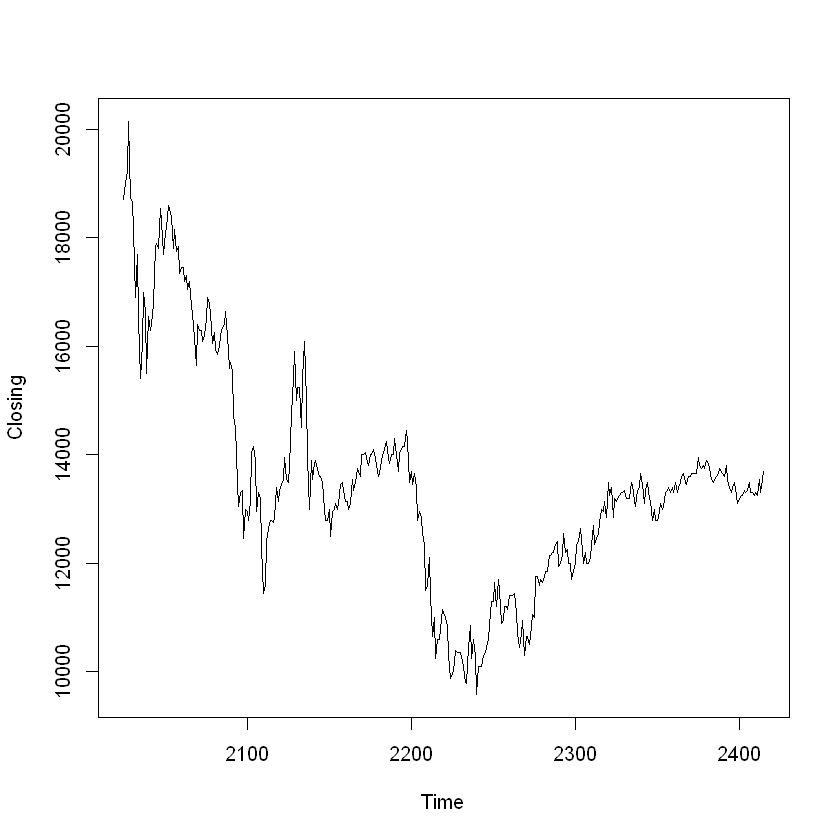

In [11]:
plot.ts(Closing)

In [12]:
ClosingDiff1 <- ts(Closing - Lag(Closing, 1), start = c(2022,as.numeric(format(as.Date('2022-01-04'), "%j"))), frequency = 365)
ClosingDiff1 <- ClosingDiff1[2:391]
ClosingDiff1_train <- ClosingDiff1[1:381]
ClosingDiff1_test <- ClosingDiff1[382:391]

In [13]:
head(ClosingDiff1, 5)

[1]   300   250   900 -1400  -100

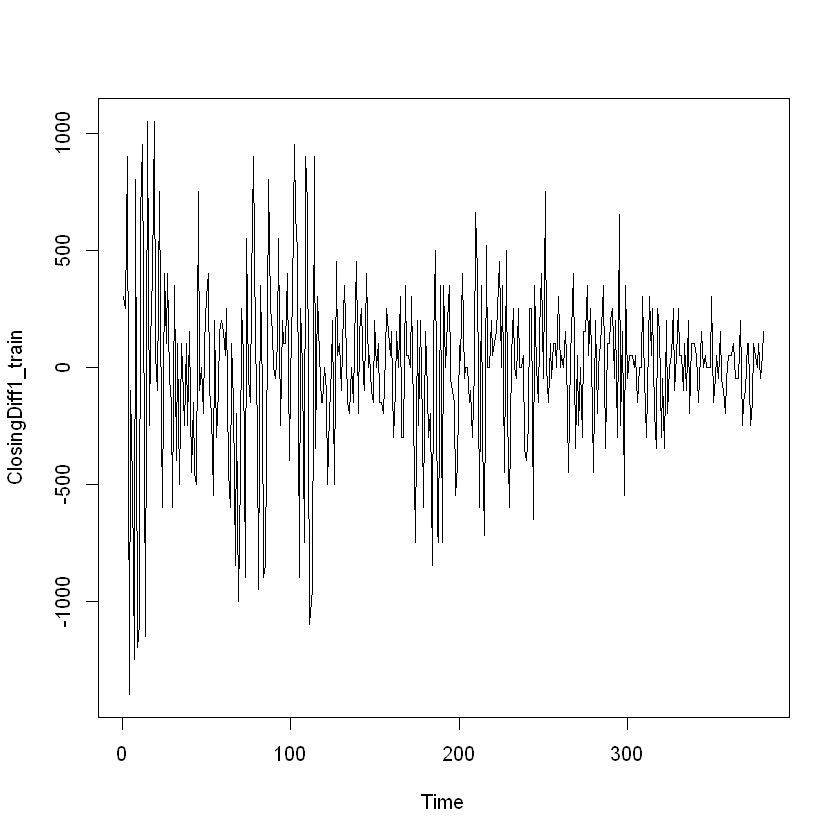

In [14]:
plot.ts(ClosingDiff1_train)

In [15]:
ClosingRelativeDiff <- ts((Closing - Lag(Closing,1))/Lag(Closing,1), start = c(2022,as.numeric(format(as.Date('2022-01-04'), "%j"))), frequency = 365)
ClosingRelativeDiff <- ClosingRelativeDiff[2:391]
ClosingRelativeDiff_train <- ClosingRelativeDiff[1:381]
ClosingRelativeDiff_test <- ClosingRelativeDiff[382:391]

In [16]:
head(ClosingRelativeDiff, 5)

[1]  0.016042781  0.013157895  0.046753247 -0.069478908 -0.005333333

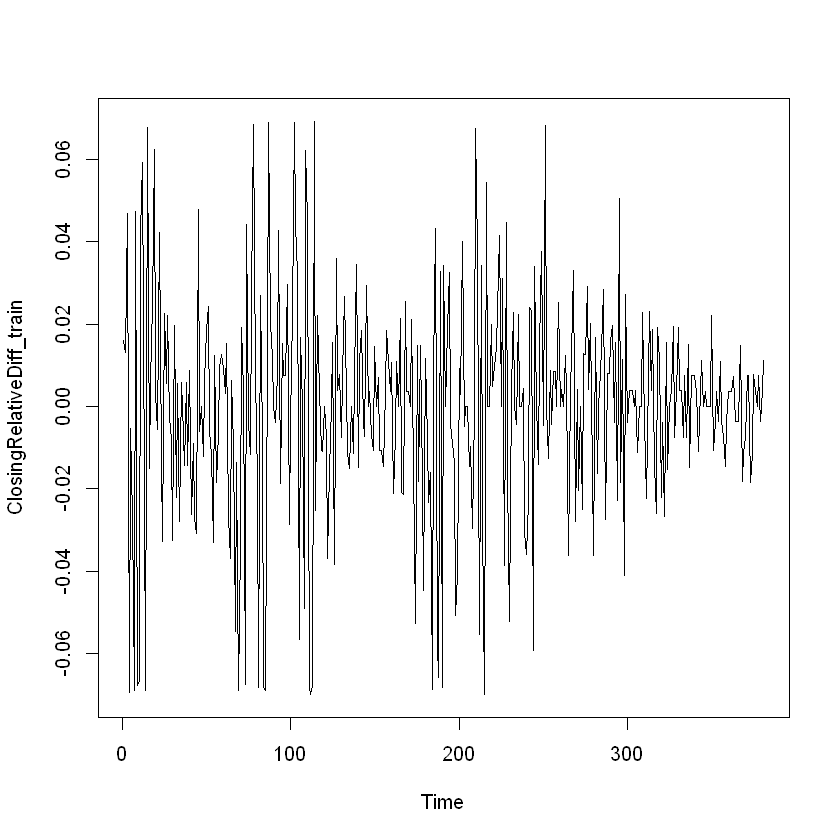

In [17]:
plot.ts(ClosingRelativeDiff_train)

In [18]:
ClosingLR <- ts(log(Closing/Lag(Closing, 1)), start = c(2022,as.numeric(format(as.Date('2022-01-04'), "%j"))), frequency = 365)
ClosingLR <- ClosingLR[2:391]
ClosingLR_train <- ClosingLR[1:381]
ClosingLR_test <- ClosingLR[382:391]

In [19]:
head(ClosingLR, 5)

[1]  0.015915455  0.013072082  0.045693228 -0.072010536 -0.005347606

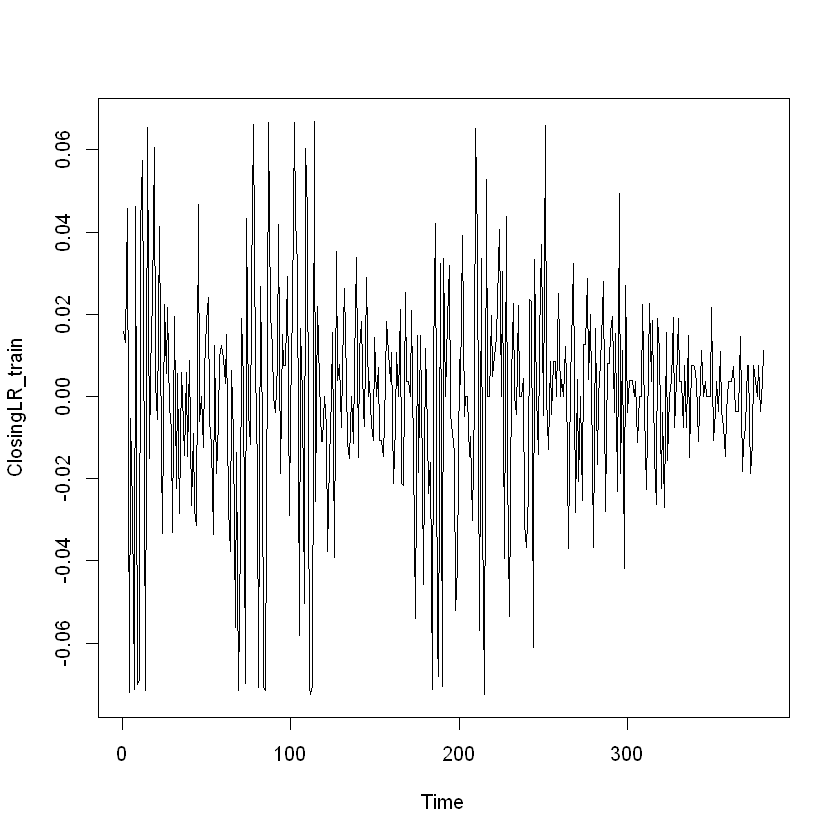

In [20]:
plot.ts(ClosingLR_train)

DF tests: Checking for stationary series

original series is not stationary


In [21]:
summary(ur.df(ClosingDiff1_train, type = "drift", selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1295.68  -149.66    33.07   189.51  1104.97 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -17.74810   19.08488  -0.930   0.3530    
z.lag.1      -1.17784    0.07443 -15.825   <2e-16 ***
z.diff.lag    0.11305    0.05117   2.209   0.0277 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 370.9 on 376 degrees of freedom
Multiple R-squared:  0.5354,	Adjusted R-squared:  0.5329 
F-statistic: 216.7 on 2 and 376 DF,  p-value: < 2.2e-16


Value of test-statistic is: -15.8254 125.2227 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2.57
phi1  6.47  4.61  3.79


In [22]:
summary(ur.df(ClosingDiff1_train, type = "none", selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-1315.72  -167.03    15.69   171.86  1086.22 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
z.lag.1    -1.17390    0.07429 -15.801   <2e-16 ***
z.diff.lag  0.11113    0.05112   2.174   0.0303 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 370.9 on 377 degrees of freedom
Multiple R-squared:  0.5343,	Adjusted R-squared:  0.5319 
F-statistic: 216.3 on 2 and 377 DF,  p-value: < 2.2e-16


Value of test-statistic is: -15.801 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


ClosingDiff1 is stationary (None)

In [23]:
summary(ur.df(ClosingRelativeDiff_train, type = "drift", selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.079835 -0.011606  0.001855  0.013517  0.072869 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.0006715  0.0013730  -0.489   0.6251    
z.lag.1     -1.1799827  0.0744905 -15.841   <2e-16 ***
z.diff.lag   0.1147661  0.0511992   2.242   0.0256 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02672 on 376 degrees of freedom
Multiple R-squared:  0.5355,	Adjusted R-squared:  0.5331 
F-statistic: 216.8 on 2 and 376 DF,  p-value: < 2.2e-16


Value of test-statistic is: -15.8407 125.4641 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2.57
phi1  6.47  4.61  3.79


In [24]:
summary(ur.df(ClosingRelativeDiff_train, type = "none", selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.08043 -0.01227  0.00119  0.01283  0.07218 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
z.lag.1    -1.17889    0.07438 -15.849   <2e-16 ***
z.diff.lag  0.11424    0.05114   2.234   0.0261 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02669 on 377 degrees of freedom
Multiple R-squared:  0.5352,	Adjusted R-squared:  0.5328 
F-statistic: 217.1 on 2 and 377 DF,  p-value: < 2.2e-16


Value of test-statistic is: -15.8492 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


ClosingRelativeDiff is stationary (None)

In [25]:
summary(ur.df(ClosingLR_train, type = 'drift', selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression drift 


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.081756 -0.011574  0.002235  0.013683  0.070876 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.001093   0.001383  -0.790   0.4298    
z.lag.1     -1.172512   0.074401 -15.759   <2e-16 ***
z.diff.lag   0.111274   0.051220   2.172   0.0304 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0269 on 376 degrees of freedom
Multiple R-squared:  0.5335,	Adjusted R-squared:  0.531 
F-statistic:   215 on 2 and 376 DF,  p-value: < 2.2e-16


Value of test-statistic is: -15.7594 124.1798 

Critical values for test statistics: 
      1pct  5pct 10pct
tau2 -3.44 -2.87 -2.57
phi1  6.47  4.61  3.79


In [26]:
summary(ur.df(ClosingLR_train, type = 'none', selectlags = "AIC"))


############################################### 
# Augmented Dickey-Fuller Test Unit Root Test # 
############################################### 

Test regression none 


Call:
lm(formula = z.diff ~ z.lag.1 - 1 + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.082641 -0.012754  0.001162  0.012625  0.069737 

Coefficients:
           Estimate Std. Error t value Pr(>|t|)    
z.lag.1    -1.16962    0.07427 -15.747   <2e-16 ***
z.diff.lag  0.10985    0.05116   2.147   0.0324 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.02688 on 377 degrees of freedom
Multiple R-squared:  0.5327,	Adjusted R-squared:  0.5302 
F-statistic: 214.9 on 2 and 377 DF,  p-value: < 2.2e-16


Value of test-statistic is: -15.7474 

Critical values for test statistics: 
      1pct  5pct 10pct
tau1 -2.58 -1.95 -1.62


ClosingLR is stationary

Checking for ACF, PACF to apply to ARMA models for ClosingDiff1, ClosingRelativeDiff and ClosingLR

In [27]:
qnorm(1-0.05/2)/sqrt(length(ClosingDiff1_train))

[1] 0.100412

ClosingDiff1 


Autocorrelations of series 'ClosingDiff1_train', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.057 -0.109  0.053  0.023 -0.019 -0.003  0.028 -0.038 -0.028  0.031 
    11     12     13     14     15     16     17     18     19     20     21 
-0.017 -0.058 -0.038  0.093 -0.028  0.039  0.015 -0.050 -0.046 -0.051 -0.035 
    22     23     24     25 
-0.069  0.020 -0.009  0.038 


Partial autocorrelations of series 'ClosingDiff1_train', by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.057 -0.113  0.041  0.017 -0.007 -0.003  0.024 -0.036 -0.027  0.018 -0.018 
    12     13     14     15     16     17     18     19     20     21     22 
-0.052 -0.051  0.077 -0.020  0.062  0.006 -0.039 -0.052 -0.074 -0.060 -0.079 
    23     24     25 
 0.009 -0.025  0.055 

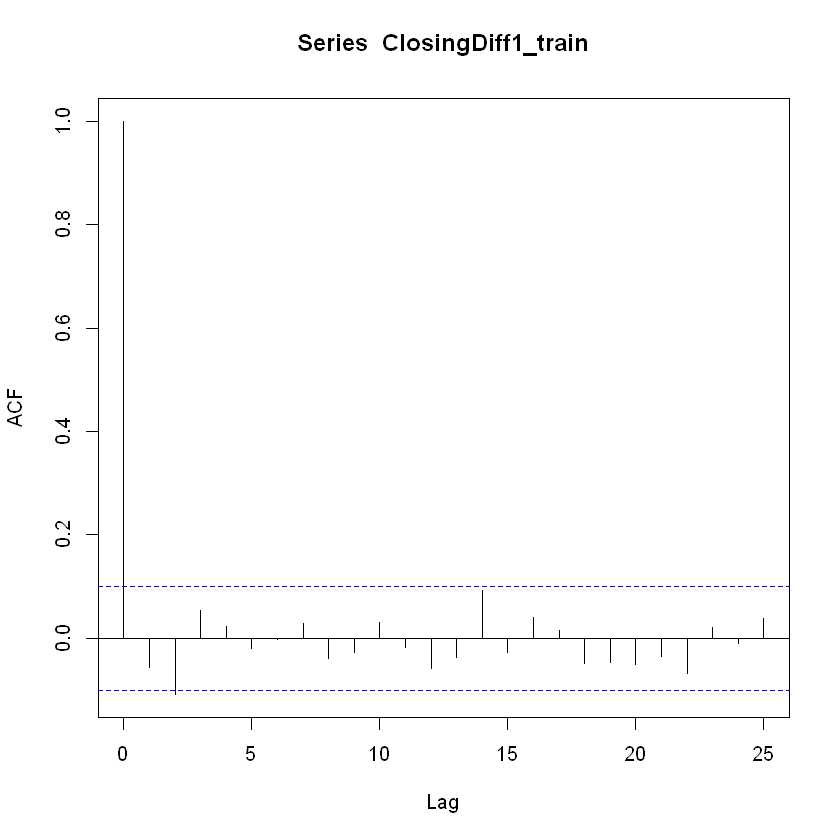

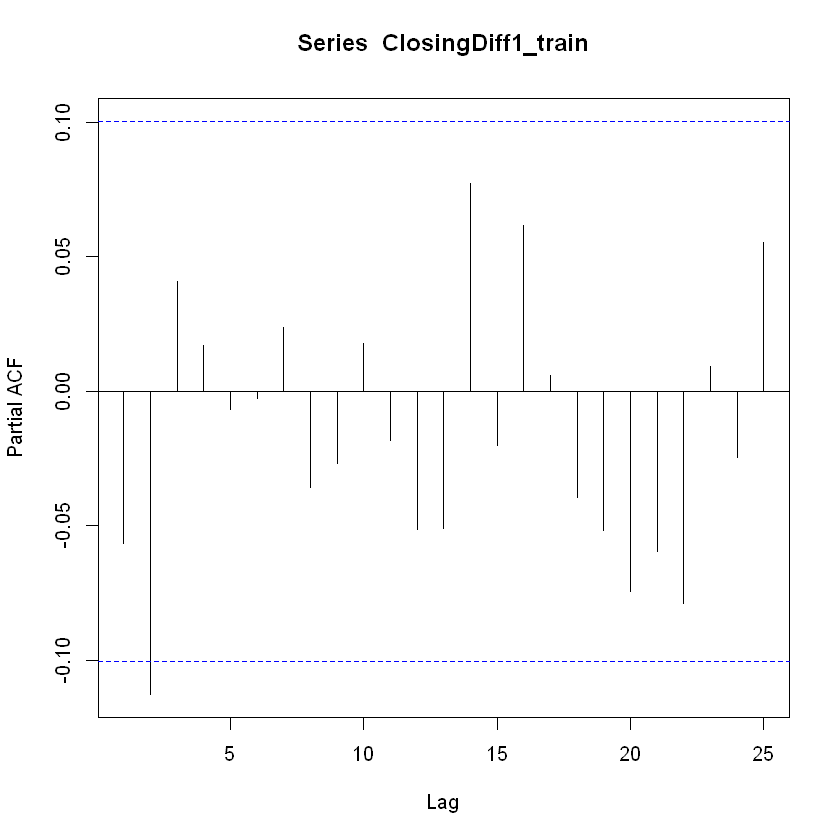

In [28]:
#ARMA(-2,-2)
acf(ClosingDiff1_train, plot = FALSE)
pacf(ClosingDiff1_train, plot = FALSE)
acf(ClosingDiff1_train)
pacf(ClosingDiff1_train)

ClosingRelativeDiff 


Autocorrelations of series 'ClosingRelativeDiff_train', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.058 -0.111  0.043  0.005 -0.029  0.007 -0.001  0.003 -0.002  0.014 
    11     12     13     14     15     16     17     18     19     20     21 
 0.007 -0.063 -0.031  0.089 -0.003  0.050  0.015 -0.040 -0.042 -0.096 -0.028 
    22     23     24     25 
-0.051  0.000 -0.009  0.051 


Partial autocorrelations of series 'ClosingRelativeDiff_train', by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.058 -0.115  0.030 -0.003 -0.021  0.003 -0.006  0.005 -0.003  0.015  0.009 
    12     13     14     15     16     17     18     19     20     21     22 
-0.060 -0.039  0.073  0.005  0.072  0.014 -0.028 -0.045 -0.114 -0.047 -0.078 
    23     24     25 
-0.009 -0.028  0.047 

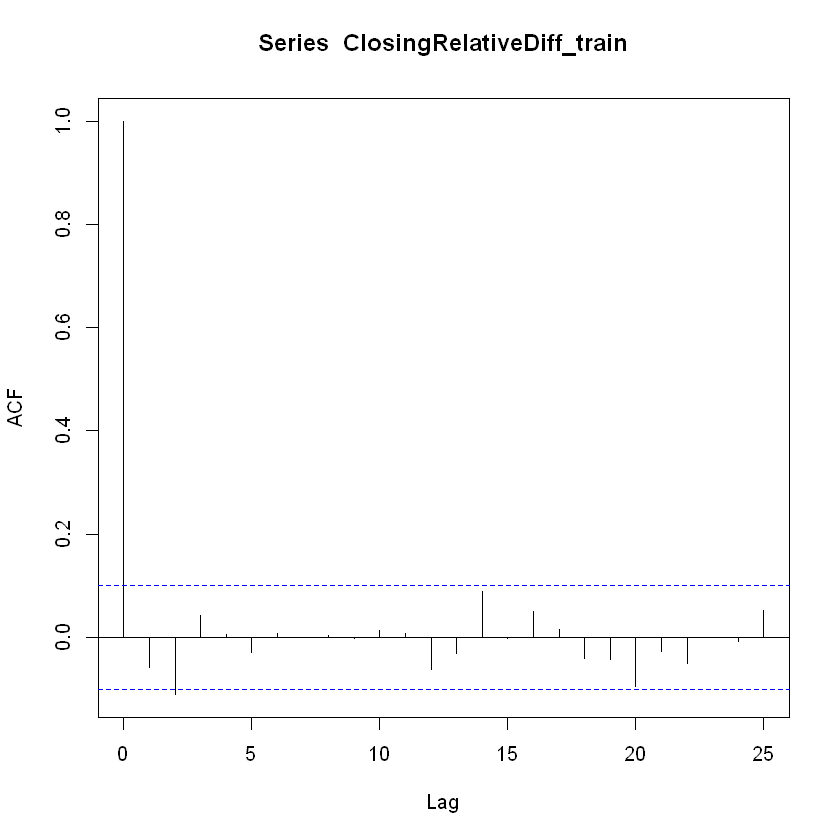

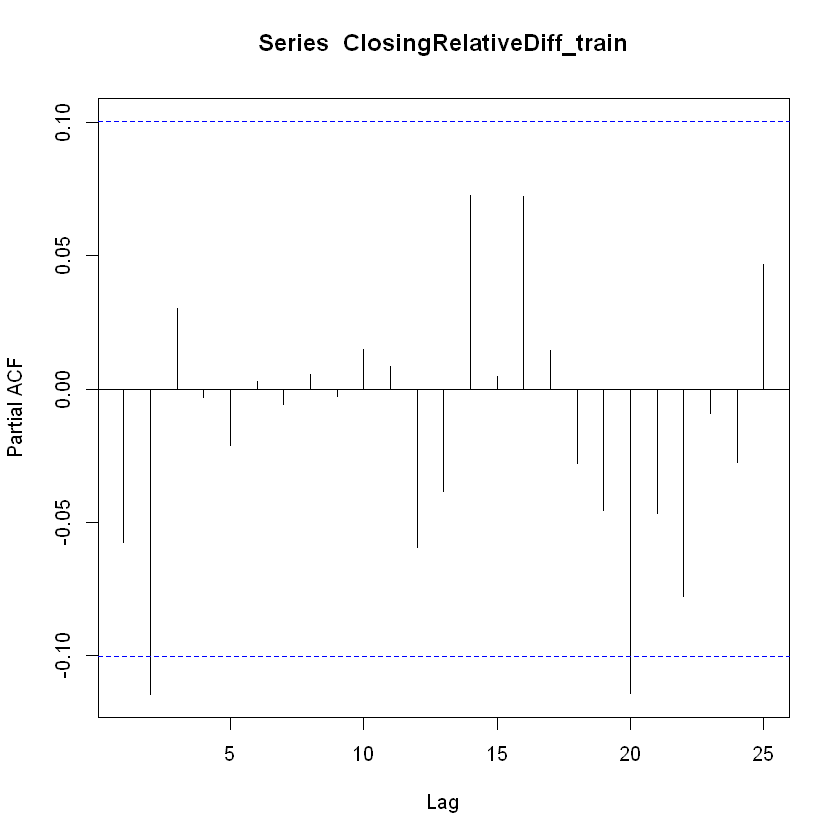

In [29]:
#ARMA(-2,-2)
acf(ClosingRelativeDiff_train, plot = FALSE)
pacf(ClosingRelativeDiff_train, plot = FALSE)
acf(ClosingRelativeDiff_train)
pacf(ClosingRelativeDiff_train)

ClosingLR 


Autocorrelations of series 'ClosingLR_train', by lag

     0      1      2      3      4      5      6      7      8      9     10 
 1.000 -0.054 -0.108  0.048  0.005 -0.029  0.008 -0.003  0.001 -0.003  0.015 
    11     12     13     14     15     16     17     18     19     20     21 
 0.008 -0.062 -0.032  0.090 -0.001  0.048  0.015 -0.040 -0.045 -0.094 -0.027 
    22     23     24     25 
-0.051 -0.003 -0.007  0.051 


Partial autocorrelations of series 'ClosingLR_train', by lag

     1      2      3      4      5      6      7      8      9     10     11 
-0.054 -0.111  0.036 -0.002 -0.020  0.004 -0.008  0.004 -0.005  0.016  0.009 
    12     13     14     15     16     17     18     19     20     21     22 
-0.059 -0.039  0.074  0.007  0.070  0.014 -0.028 -0.049 -0.113 -0.045 -0.076 
    23     24     25 
-0.009 -0.025  0.047 

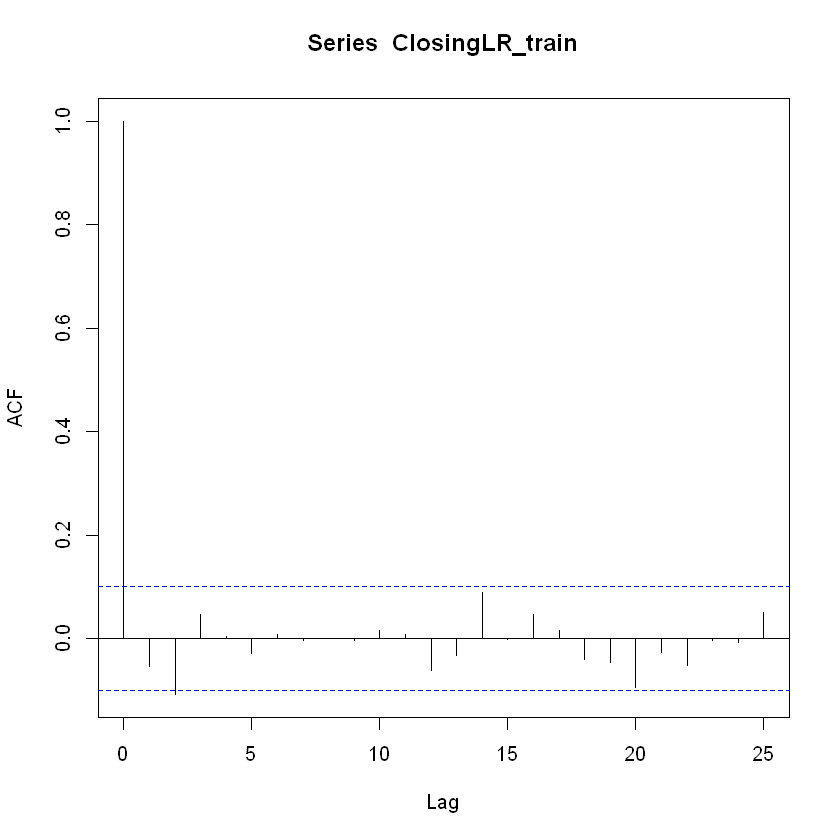

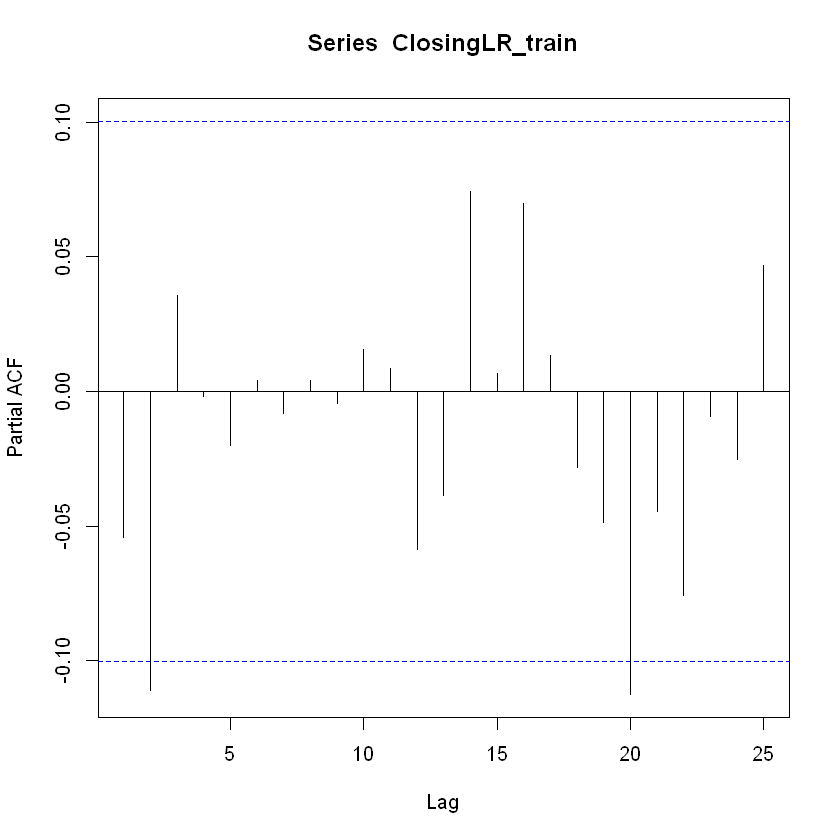

In [30]:
#ARMA(-2,-2)
acf(ClosingLR_train, plot = FALSE)
pacf(ClosingLR_train, plot = FALSE)
acf(ClosingLR_train)
pacf(ClosingLR_train)

# Fitting ARIMA models

#### ClosingDiff1

In [31]:
summary(arima(ClosingDiff1_train, order = c(2,0,2)))


Call:
arima(x = ClosingDiff1_train, order = c(2, 0, 2))

Coefficients:
          ar1      ar2     ma1     ma2  intercept
      -0.3101  -0.4381  0.2531  0.3209   -13.7542
s.e.   0.3702   0.5809  0.3946  0.6113    17.0124

sigma^2 estimated as 135948:  log likelihood = -2792.35,  aic = 5596.7

Training set error measures:
                     ME     RMSE     MAE MPE MAPE      MASE         ACF1
Training set 0.05101691 368.7118 262.162 NaN  Inf 0.6871875 -0.001832182

In [32]:
summary(arma(ClosingDiff1_train, order = c(2,2)))


Call:
arma(x = ClosingDiff1_train, order = c(2, 2))

Model:
ARMA(2,2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1535.58  -157.01    46.11   202.64  1199.53 

Coefficient(s):
           Estimate  Std. Error  t value Pr(>|t|)    
ar1         0.73181     0.09416    7.772 7.77e-15 ***
ar2        -0.89597     0.17326   -5.171 2.32e-07 ***
ma1        -0.77487     0.06947  -11.155  < 2e-16 ***
ma2         0.89561     0.17064    5.249 1.53e-07 ***
intercept -29.35964    21.14551   -1.388    0.165    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Fit:
sigma^2 estimated as 135996,  Conditional Sum-of-Squares = 51453909,  AIC = 5594.8


In [33]:
rmse(ClosingDiff1_train[3:381], arma(ClosingDiff1_train, order = c(2,2))$fitted[3:381])

[1] 368.4593

In [34]:
summary(arima(ClosingDiff1_train, order = c(2,0,2), fixed = c(0, NA, 0, NA, NA)))

Warning message in arima(ClosingDiff1_train, order = c(2, 0, 2), fixed = c(0, NA, :
"some AR parameters were fixed: setting transform.pars = FALSE"



Call:
arima(x = ClosingDiff1_train, order = c(2, 0, 2), fixed = c(0, NA, 0, NA, NA))

Coefficients:
      ar1      ar2  ma1     ma2  intercept
        0  -0.2073    0  0.0993   -13.8506
s.e.    0   0.4075    0  0.4139    17.2604

sigma^2 estimated as 136790:  log likelihood = -2793.52,  aic = 5595.04

Training set error measures:
                    ME     RMSE      MAE MPE MAPE      MASE        ACF1
Training set 0.1578246 369.8518 263.8667 NaN  Inf 0.6916558 -0.05877357

#### ClosingRelativeDiff

In [35]:
summary(arma(ClosingRelativeDiff_train, order = c(2,2)))


Call:
arma(x = ClosingRelativeDiff_train, order = c(2, 2))

Model:
ARMA(2,2)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.080736 -0.011605  0.002051  0.013456  0.072773 

Coefficient(s):
            Estimate  Std. Error  t value Pr(>|t|)
ar1       -0.0631238   0.4248428   -0.149    0.882
ar2       -0.2165880   0.3475072   -0.623    0.533
ma1       -0.0039506   0.4346674   -0.009    0.993
ma2        0.1067392   0.3684542    0.290    0.772
intercept -0.0007119   0.0015170   -0.469    0.639

Fit:
sigma^2 estimated as 0.0007099,  Conditional Sum-of-Squares = 0.27,  AIC = -1671.17


In [36]:
rmse(ClosingRelativeDiff_train[3:381], arma(ClosingRelativeDiff_train, order = c(2,2))$fitted[3:381])

[1] 0.0266087

In [37]:
summary(arima(ClosingRelativeDiff_train, order = c(2,0,2)))


Call:
arima(x = ClosingRelativeDiff_train, order = c(2, 0, 2))

Coefficients:
          ar1      ar2     ma1     ma2  intercept
      -0.3016  -0.2161  0.2413  0.0903    -0.0005
s.e.   0.3938   0.4109  0.4020  0.4189     0.0012

sigma^2 estimated as 0.000705:  log likelihood = 841.89,  aic = -1671.78

Training set error measures:
                       ME       RMSE        MAE MPE MAPE      MASE
Training set 4.415847e-06 0.02655162 0.01920564 NaN  Inf 0.6828172
                      ACF1
Training set -0.0004134073

In [38]:
summary(arima(ClosingRelativeDiff_train, order = c(2,0,2), fixed = c(0, NA, 0, NA, NA)))

Warning message in arima(ClosingRelativeDiff_train, order = c(2, 0, 2), fixed = c(0, :
"some AR parameters were fixed: setting transform.pars = FALSE"



Call:
arima(x = ClosingRelativeDiff_train, order = c(2, 0, 2), fixed = c(0, NA, 0, 
    NA, NA))

Coefficients:
      ar1      ar2  ma1      ma2  intercept
        0  -0.0596    0  -0.0517    -0.0005
s.e.    0   0.4342    0   0.4346     0.0012

sigma^2 estimated as 0.0007086:  log likelihood = 840.91,  aic = -1673.83

Training set error measures:
                       ME       RMSE        MAE MPE MAPE      MASE        ACF1
Training set 6.565962e-06 0.02661992 0.01933251 NaN  Inf 0.6873276 -0.06068333

#### ClosingLR

In [39]:
summary(arima(ClosingLR_train, order = c(2,0,2)))


Call:
arima(x = ClosingLR_train, order = c(2, 0, 2))

Coefficients:
          ar1      ar2     ma1     ma2  intercept
      -0.3440  -0.2676  0.2883  0.1448    -0.0009
s.e.   0.3956   0.4009  0.4064  0.4122     0.0012

sigma^2 estimated as 0.0007142:  log likelihood = 839.43,  aic = -1666.86

Training set error measures:
                       ME       RMSE        MAE MPE MAPE      MASE
Training set 2.680341e-06 0.02672373 0.01931957 NaN  Inf 0.6853214
                      ACF1
Training set -0.0004952707

In [40]:
summary(arima(ClosingLR_train, order = c(2,0,2), fixed = c(0, NA, 0, NA, NA)))

Warning message in arima(ClosingLR_train, order = c(2, 0, 2), fixed = c(0, NA, 0, :
"some AR parameters were fixed: setting transform.pars = FALSE"



Call:
arima(x = ClosingLR_train, order = c(2, 0, 2), fixed = c(0, NA, 0, NA, NA))

Coefficients:
      ar1      ar2  ma1      ma2  intercept
        0  -0.0624    0  -0.0458    -0.0009
s.e.    0   0.4426    0   0.4430     0.0012

sigma^2 estimated as 0.0007178:  log likelihood = 838.47,  aic = -1668.93

Training set error measures:
                       ME       RMSE        MAE MPE MAPE      MASE        ACF1
Training set 7.910803e-06 0.02679162 0.01943478 NaN  Inf 0.6894081 -0.05619809

In [41]:
summary(arma(ClosingLR_train, order = c(2,2)))


Call:
arma(x = ClosingLR_train, order = c(2, 2))

Model:
ARMA(2,2)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.083060 -0.011419  0.002451  0.013809  0.070795 

Coefficient(s):
           Estimate  Std. Error  t value Pr(>|t|)
ar1       -0.101243    0.402165   -0.252    0.801
ar2       -0.226601    0.354431   -0.639    0.523
ma1        0.037893    0.411075    0.092    0.927
ma2        0.115814    0.371897    0.311    0.755
intercept -0.001224    0.001633   -0.749    0.454

Fit:
sigma^2 estimated as 0.0007193,  Conditional Sum-of-Squares = 0.27,  AIC = -1666.15


In [42]:
rmse(ClosingLR_train[3:381], arma(ClosingLR_train, order = c(2,2))$fitted[3:381])

[1] 0.0267844

## Forecasting

##### Model 1: LS estimation ClosingDiff1 ARIMA(2,0,2)

In [51]:
tail(arma(ClosingDiff1_train, order = c(2,2))$resid)

[1]  48.56719  33.52185 156.63568  -2.47208  63.34673 149.27010

In [52]:
ClosingDiff1_test

[1] -200    0  -50   50  -50  300 -250  250  150   NA